In [12]:
# Import dependencies
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
pd.set_option('max_colwidth', 400)
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
from lazypredict.Supervised import LazyClassifier, LazyRegressor

In [4]:
# Read the transformed data into a Pandas DataFrame
df = pd.read_csv('Resources/pnw_final.csv')
df

,time,latitude,longitude,depth,mag,magType,nst,gap,dmin,rms,...,depthError,magError,magNst,status,locationSource,magSource,year,month,day,hour
0,2025-05-20 09:29:32.099000+00:00,41.91,-119.58,12.80,2.70,ml,6.00,130.95,0.35,0.11,...,4.00,0.39,6.00,reviewed,nn,nn,2025,5,20,9
1,2025-05-19 03:03:05.700000+00:00,40.37,-125.10,0.33,2.74,md,22.00,271.00,0.59,0.32,...,13.38,0.11,15.00,automatic,nc,nc,2025,5,19,3
2,2025-05-17 05:51:18.640000+00:00,40.27,-124.63,5.63,3.50,mw,83.00,245.00,0.22,0.23,...,0.68,0.12,6.00,reviewed,nc,nc,2025,5,17,5
3,2025-05-17 05:21:49.130000+00:00,40.30,-124.51,5.88,2.93,md,24.00,273.00,0.13,0.30,...,1.75,0.08,26.00,automatic,nc,nc,2025,5,17,5
4,2025-05-17 05:06:00.660000+00:00,40.29,-124.57,8.36,2.95,ml,26.00,278.00,0.18,0.15,...,1.30,0.15,4.00,automatic,nc,nc,2025,5,17,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18473,1970-08-08 22:36:40.160000+00:00,47.37,-123.11,35.99,2.90,md,5.00,185.00,0.28,0.17,...,2.66,0.06,4.00,reviewed,uw,uw,1970,8,8,22
18474,1970-07-29 20:42:31.210000+00:00,48.20,-119.49,20.26,2.70,md,11.00,324.00,1.03,0.36,...,6.15,0.25,0.00,reviewed,uw,uw,1970,7,29,20
18475,1970-07-11 10:24:30.860000+00:00,48.20,-121.36,0.04,3.00,md,4.00,296.00,0.89,0.10,...,0.13,0.07,4.00,reviewed,uw,uw,1970,7,11,10
18476,1970-05-06 17:15:38.030000+00:00,46.88,-119.46,0.92,2.50,md,5.00,148.00,0.11,0.19,...,2.80,0.24,0.00,reviewed,uw,uw,1970,5,6,17


In [14]:
df.columns

Index(['time', 'latitude', 'longitude', 'depth', 'mag', 'magType', 'nst',
       'gap', 'dmin', 'rms', 'net', 'id', 'updated', 'place', 'type',
       'horizontalError', 'depthError', 'magError', 'magNst', 'status',
       'locationSource', 'magSource', 'year', 'month', 'day', 'hour'],
      dtype='object')

## Exploratory Plots

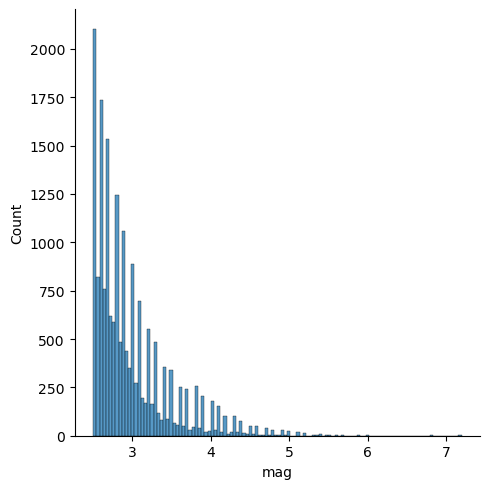

In [5]:
sns.displot(df['mag'])

The sharp peak near 2.0 -3.0 indicates that most earthquakes in this dataset are small, which is typical for natural seismicity. The long tail to the right indicates that there are larger quakes (magnitude 4-7) but rare. 

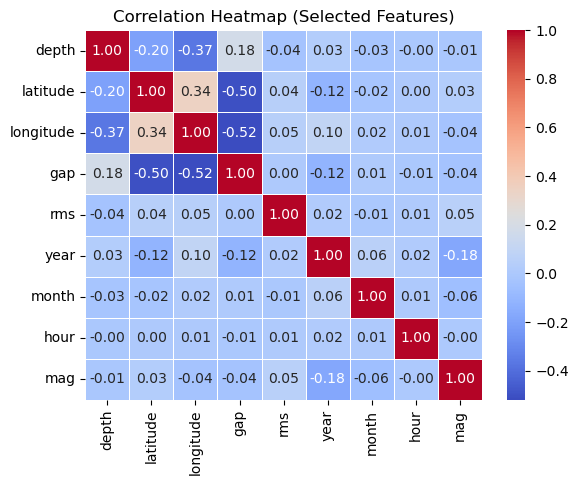

In [6]:
# Choose relevant numerical features
selected_cols = ['depth', 'latitude', 'longitude', 'gap', 'rms', 'year', 'month', 'hour', 'mag']

# Compute correlation matrix for just those columns
corr_matrix = df[selected_cols].corr()

# Plot heatmap
plt.figure()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Correlation Heatmap (Selected Features)")
plt.show()

This matrix shows Pearson correlation coefficients between each pair of selected features. It can be seen that magnitude (which will be the target variable) correlates weakly with all predictors. In other words, earthquake magnitude isn't strongly linearly related to any single feature — which is why more complex models like Random Forests will be useful.

Mag vs year: -0.18 suggests a slight decrease in average magnitude over time — could reflect changes in detection thresholds or real seismic behavior.

Month and hour are largely uncorrelated with anything. This shows no evidence of seasonal or time-of-day influence — expected for natural earthquakes.

## Training the models

In [7]:
# Define features and target
features = ['depth', 'latitude', 'longitude', 'year', 'month', 'hour']
target = 'mag'

X = df[features]
y = df[target]

In [8]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [9]:
# Scale
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [5]:
# Linear Regression Model
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)
lr_preds = lr_model.predict(X_test)

In [6]:
# Random Forest Regressor
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
rf_preds = rf_model.predict(X_test)

## Evaluation of the models 

In [7]:
print("🔹 Linear Regression")
print("MAE:", mean_absolute_error(y_test, lr_preds))
print("R²:", r2_score(y_test, lr_preds))

🔹 Linear Regression
MAE: 0.35993099681809165
R²: 0.027332519223118967


In [8]:
print("\n🔹 Random Forest Regressor")
print("MAE:", mean_absolute_error(y_test, rf_preds))
print("R²:", r2_score(y_test, rf_preds))


🔹 Random Forest Regressor
MAE: 0.32538866341991346
R²: 0.19025735218760542


##### MAE
This shows the average absolute difference between predicted and actual earthquake magnitudes. Since this tells us how far off our predictions are on average, lower is better. The result for the Linear Regression model is approxiamtely 0.36 - meaning the prediction is off by 0.36 magntude units. The random forest, on the other hand, is 0.33 which is slightly better (more accurate) than the linear regression. 

##### R2
The R-squared or Coefficient of Determination measures how well the model explains the variation in the target variable. The range is between 0 and 1 and higher is better. In our models, the value is 0.03 and 0.19 for Linear Regression and Random Forest respectively. While only 3% of the variance in magnitudes is explained in the linear regression, there is a noticable improvement in the random forest which explains 19 % of the magnitude variance. 

However, an R2 value of 0.19 still means that the model leaves a lot of earthquake behavior unexplained. 

## Feature Expansion + Grid Search 

In [21]:
# Encode 'magType' as categorical
le = LabelEncoder()
df['magType_encoded'] = le.fit_transform(df['magType'])

In [22]:
# Updated feature list
features = ['depth', 'latitude', 'longitude', 'year', 'month', 'hour', 'gap', 'rms', 'magType_encoded','nst', 'dmin', 'horizontalError', 'depthError', 'magError']
target = 'mag'

X = df[features]
y = df[target]

In [23]:
# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [24]:
# Hyperparameter tuning
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5]
}

grid_search = GridSearchCV(RandomForestRegressor(random_state=42), param_grid, cv=3, scoring='neg_mean_absolute_error')
grid_search.fit(X_train, y_train)

GridSearchCV(cv=3, estimator=RandomForestRegressor(random_state=42),
             param_grid={'max_depth': [None, 10, 20],
                         'min_samples_split': [2, 5],
                         'n_estimators': [100, 200]},
             scoring='neg_mean_absolute_error')

In [13]:
# Best model
best_rf = grid_search.best_estimator_
rf_preds = best_rf.predict(X_test)

In [14]:
# Evaluation
print("Best Params:", grid_search.best_params_)
print("MAE:", mean_absolute_error(y_test, rf_preds))
print("R²:", r2_score(y_test, rf_preds))

Best Params: {'max_depth': 20, 'min_samples_split': 5, 'n_estimators': 200}
MAE: 0.2399893804481306
R²: 0.5441280184488366


After the use of more features and fine-tuning the random forest, the MAE improved to 0.24, meaning our predictions are off by 0.24 magnitude units - a major improvement from the previous result. Similarily, the R-squared has improved to 0.54; the model now explains 54% of the variance in earthquake magnitude. This can be considered a good result in geophysical prediction. 

### Adding more features 

In [15]:
df.columns

Index(['time', 'latitude', 'longitude', 'depth', 'mag', 'magType', 'nst',
       'gap', 'dmin', 'rms', 'net', 'id', 'updated', 'place', 'type',
       'horizontalError', 'depthError', 'magError', 'magNst', 'status',
       'locationSource', 'magSource', 'year', 'month', 'day', 'hour'],
      dtype='object')

In [18]:
# Adding more features 
features = ['depth', 'latitude', 'longitude', 'year', 'month', 'hour', 'gap', 'rms', 
            'magType', 'nst', 'dmin', 'horizontalError', 'depthError', 'magError']
target = 'mag'

X = df[features]
y = df[target]

In [19]:
# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Feature Importance Visualization 

In [25]:
# Train the tuned Random Forest model
rf_model = RandomForestRegressor(
    n_estimators=200, max_depth=20, min_samples_split=5, random_state=42
)
rf_model.fit(X_train, y_train)

RandomForestRegressor(max_depth=20, min_samples_split=5, n_estimators=200,
                      random_state=42)

In [26]:
# Extract feature importances
importances = rf_model.feature_importances_
importance_df = pd.DataFrame({
    'Feature': features,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

C:\Users\sofon\AppData\Local\Temp\ipykernel_25248\2885160798.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=importance_df, palette='viridis')


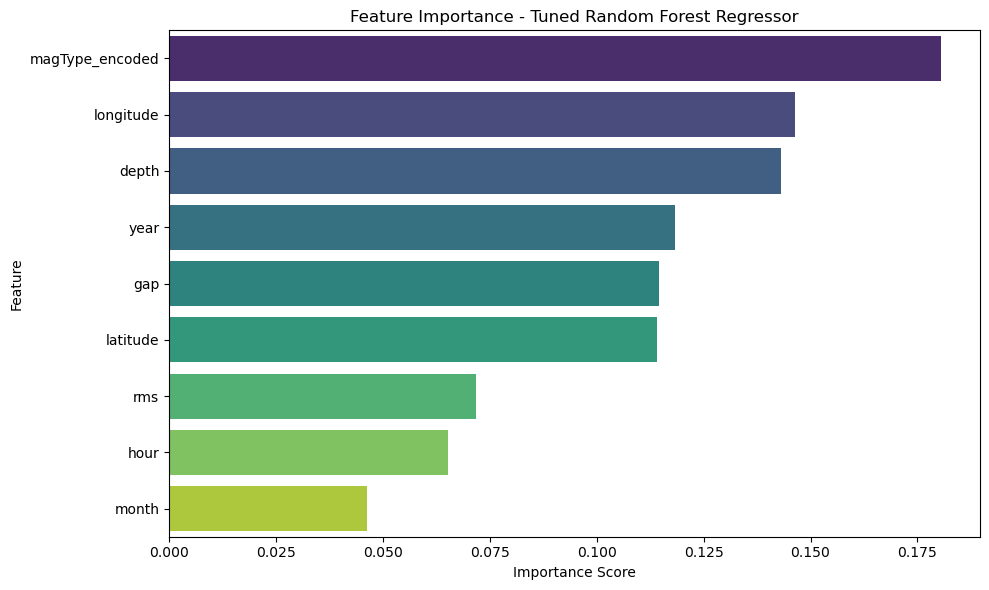

In [27]:
# Plot
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df, palette='viridis')
plt.title("Feature Importance - Tuned Random Forest Regressor")
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

What the Chart Shows:

Each bar represents how much a feature contributes to predicting earthquake magnitude — based on how often and how effectively it's used to split decision trees in the Random Forest.

Most important features:

* magType_encoded is the moset important feature and it directly reflects how the magnitude was measured which often correlates with the value itself.
* year is the second most important feature. This could relate to earthquake reporting methods, equipment precision, and regional seismic activity changing over time. This helps the model detect temporal trends in magnitudes.  

Moderately important features:

* depth - deeper quakes may release energy differently than shallow ones. This can have a strong influence on magnitude. 
* longitude, latutude - these help localize quake behavior and may correlate with tectonic zones or faults. 
* gap - represents how wide the angle is between seismic stations and impacts how well an event is located/measured. 

Least important features:

* rms - measures the consistency of the recorded seismic waveforms.
* hour, month - time-of-day and month have minimal relationship to how strong a quake is - earthquakes do not follow human or seasonal cycles. 

Summary

The model heavily relies on magType and year suggesting measurement method and time trends matter. Geograhical features like depth, gap, and location also contribute meaningfully. 

## Switching to Classification

In [19]:
# Create binary target: 1 if mag ≥ 4.0
df['high_mag'] = (df['mag'] >= 4.0).astype(int)

In [20]:
# Define features and target
features = ['depth', 'latitude', 'longitude', 'year', 'month', 'hour', 'gap', 'rms', 'magType_encoded']
X = df[features]
y = df['high_mag']

In [21]:
# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [22]:
# Train classifier
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [23]:
# Evaluate
y_pred = clf.predict(X_test)
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Confusion Matrix:
 [[3433   37]
 [ 134   92]]

Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.99      0.98      3470
           1       0.71      0.41      0.52       226

    accuracy                           0.95      3696
   macro avg       0.84      0.70      0.75      3696
weighted avg       0.95      0.95      0.95      3696



Calssification Report:

Class 0 (Low Magnitude) 